# Setup

In [1]:
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2 as cv
import math

In [3]:
## Execute this when running the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage"

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# When running in local
folder_path = ""

In [4]:
image_file = "Test.png"
image_path = f"{folder_path}scan_resultsheets/Test/{image_file}"
print(image_path)

scan_resultsheets/Test/Test.png


# Detection of boxes contours

## Functions

In [5]:
def affiche_scan(img):
    # Display scanned resultsheet with horizontal and vertical lines
    rows,cols, _ = img.shape
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axhline(rows//2, color='r', linewidth=1)
    plt.axvline(cols//2, color='g', linewidth=1)
    plt.show()
def image_rotation(img, degree):
    # Rotate an image of a certain degree counterclockwise
    rows,cols, _ = img.shape
    M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),degree,1)
    img_rot = cv.warpAffine(img,M,(cols,rows))
    affiche_scan(img_rot)
    return img_rot

In [6]:
# Function to detect box contours
def extract_boxes(img, lower_TS):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, lower_TS, 250, cv.THRESH_BINARY_INV) # Modify threshold in case of issues with box detection
    # In case of threshold optimisation: visualise thresholded image
    #plt.imshow(thresh)
    #plt.show()
    contours, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    extracted_boxes = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if(w>=90 and w<100):
            aspect_ratio = w/h
            if aspect_ratio <= 1.15:
                extracted_boxes.append((x, y, w, h))
    # Reorder box list to have top to bottom list
    extracted_boxes = np.array(extracted_boxes)
    extracted_boxes = np.flip(extracted_boxes, axis=0)
    return extracted_boxes

In [7]:
# Function to visualize detected boxes on scanned resultsheet
def plot_boxes(image, boxes):
    image_copy = image.copy()
    if boxes.ndim > 1:
        for gbox in boxes :
            x, y, w, h = gbox
            cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else :
        x, y, w, h = boxes
        cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(10,8))
    plt.imshow(cv.cvtColor(image_copy, cv.COLOR_BGR2RGB))
    plt.title("Detected Boxes")
    plt.axis('off')
    plt.show()

In [8]:
def reorder_box(box):
    # We want boxes in order : left -> right (x asc), top -> bottom (y asc)
    # To avoid little variations in the line, which will mess up the sort
    # We replace each line and each column of 20 by the mean y and mean x
    boxdf = pd.DataFrame(box, columns = ['x', 'y', 'w', 'h'])
    boxdf_sorted = boxdf.copy()
    # Sort the df on y, and replace y for the line of 20 by mean y
    boxdf_sorted = boxdf_sorted.sort_values(by = 'y', ignore_index = True)
    for i in range(0, 400, 20):
        boxdf_sorted.loc[i:i+19, 'y'] = round(boxdf_sorted.loc[i:i+19, 'y'].mean(), 0)
    # Sort the df on x, and replace x for the line of 20 by mean x
    boxdf_sorted = boxdf_sorted.sort_values(by = 'x', ignore_index = True)
    for j in range(0, 400, 20):
        boxdf_sorted.loc[j:j+19, 'x'] = round(boxdf_sorted.loc[j:j+19, 'x'].mean(), 0)
    # Finally sort by ascending y then x
    boxdf_sorted = boxdf_sorted.sort_values(by = ['y', 'x'], ignore_index = True)
    box_sorted = boxdf_sorted.to_numpy()
    return box_sorted

## Detection

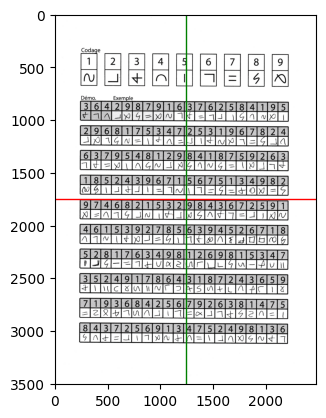

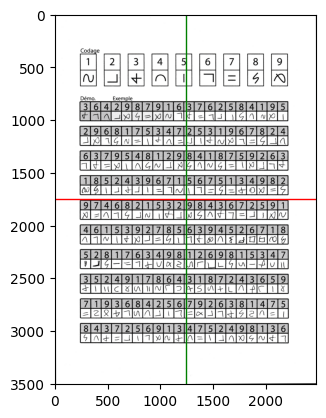

In [9]:
# Image rotation
img = cv.imread(image_path)
affiche_scan(img)
img_rot = image_rotation(img, 0.3)

In [10]:
max_box_detected = 0
lower_TSt = 0
while max_box_detected != 400 :
    lower_TSt += 1
    print(lower_TSt)
    box = extract_boxes(img_rot, lower_TSt)
    print(box.shape)
    max_box_detected = len(box)

1
(0,)
2
(0,)
3
(0,)
4
(0,)
5
(1, 4)
6
(1, 4)
7
(9, 4)
8
(14, 4)
9
(11, 4)
10
(14, 4)
11
(18, 4)
12
(57, 4)
13
(137, 4)
14
(268, 4)
15
(344, 4)
16
(375, 4)
17
(385, 4)
18
(392, 4)
19
(396, 4)
20
(397, 4)
21
(397, 4)
22
(398, 4)
23
(399, 4)
24
(399, 4)
25
(400, 4)


In [11]:
print(box.shape)
print(lower_TSt)

(400, 4)
25


In [12]:
# Do not run unless all boxes are detected
print(box.mean(axis=0))
box = reorder_box(box)
print(box.mean(axis=0))

[1175.08   1929.9625   94.3125   86.68  ]
[1175.     1929.95     94.3125   86.68  ]


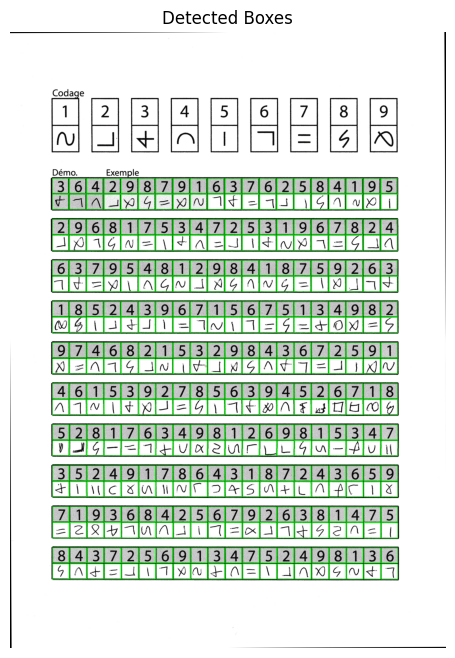

In [13]:
plot_boxes(img_rot, box)

# Extraction of symbols (ROI) located inside the boxes

## Functions

In [14]:
# Function to extract roi inside boxes
arbitrary_width = 87
arbitrary_height = 80
def extract_roi_inside_box(img, box):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    x, y, w, h = box
    roi = gray[y+4:y+arbitrary_height, x+5:x+arbitrary_width]
    return roi

In [15]:
# Function to visualize all symbols corresponding to certain labels
def visualize_symbols(images, labels, imgperrow = 12):
    for l in np.unique(labels):
        label_mask = (labels == l)
        img_indices = np.where(label_mask)[0]

        n_rows = math.ceil(len(images[img_indices]) / imgperrow)
        fig, axs = plt.subplots(n_rows, imgperrow, figsize=(imgperrow, n_rows))

        for i, pixels in enumerate(images[img_indices]):
            row = i // imgperrow
            col = i % imgperrow
            ax = axs[row, col]
            ax.imshow(pixels)
            ax.text(0.5, 1.02, str(img_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
            ax.axis('off')
        fig.suptitle(f'Label {l}', fontsize=16)
        fig.subplots_adjust(top=0.75)
        plt.show()

In [16]:
# List of index of symbols boxes
intervals = [(20, 40), (60, 80), (100, 120), (140, 160), (180, 200), (220, 240), (260, 280), (300, 320), (340, 360), (380, 400)]
symbols_index = np.concatenate([np.arange(start, end, 1) for start, end in intervals])
print(symbols_index)
# List of index of numbers boxes
all_index = np.arange(0, 400, 1)
number_index = np.setdiff1d(all_index, symbols_index)
print(number_index)

[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  80  81  82  83  84  85 

## Extraction

In [17]:
# Extraction: création de la liste de toutes les images contenues dans les boites
# Use only if all boxes are detected
roi_symbols = []
for coord in box[symbols_index] :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_symbols.append(roi_img)
roi_symbols = np.array(roi_symbols)
print(roi_symbols.shape)

(200, 76, 82)


In [18]:
# Extraction: creation of the list of all images (roi) located inside the boxes
roi_all = []
for coord in box :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_all.append(roi_img)
roi_all = np.array(roi_all)
print(roi_all.shape)

(400, 76, 82)


In [19]:
# Extraction: création de la liste de toutes les images contenues dans les boites
# Use only if all boxes are detected
roi_numbers = []
for coord in box[number_index] :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_numbers.append(roi_img)
roi_numbers = np.array(roi_numbers)
print(roi_numbers.shape)

(200, 76, 82)


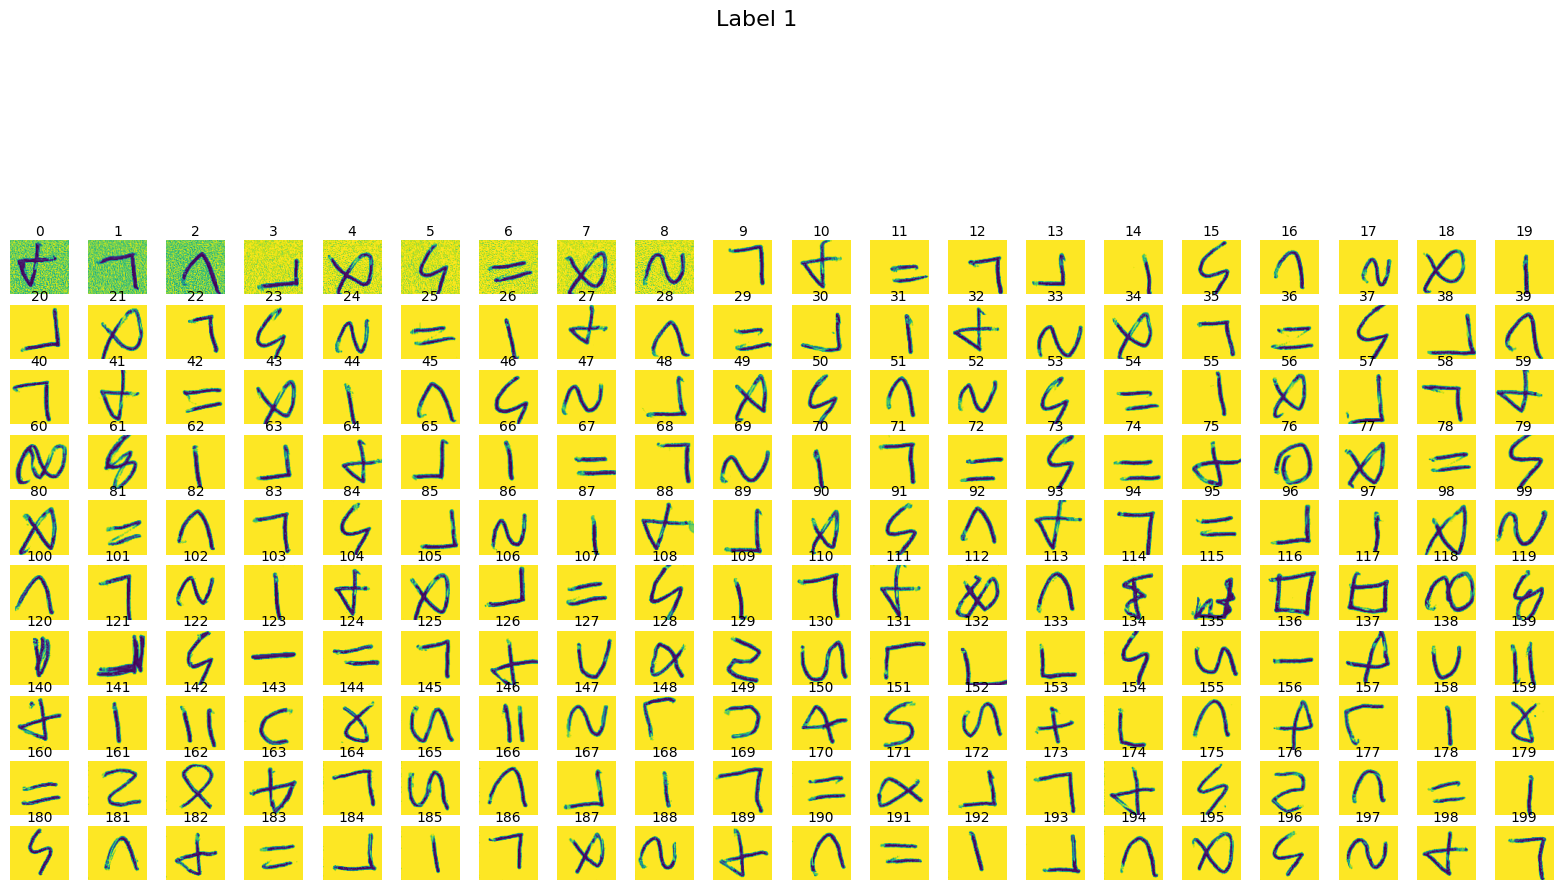

In [20]:
labels_blank = np.ones(len(roi_symbols), dtype=int)
visualize_symbols(roi_symbols, labels_blank, 20)

# Correction

In [21]:
true_labels = np.array([3, 6, 4, 2, 9, 8, 7, 9, 1, 6, 3, 7, 6, 2, 5, 8, 4, 1, 9, 5,
                        2, 9, 6, 8, 1, 7, 5, 3, 4, 7, 2, 5, 3, 1, 9, 6, 7, 8, 2, 4,
                        6, 3, 7, 9, 5, 4, 8, 1, 2, 9, 8, 4, 1, 8, 7, 5, 9, 2, 6, 3,
                        1, 8, 5, 2, 4, 3, 9, 6, 7, 1, 5, 6, 7, 5, 1, 3, 4, 9, 8, 2, 
                        9, 7, 4, 6, 8, 2, 1, 5, 3, 2, 9, 8, 4, 3, 6, 7, 2, 5, 9, 1,
                        4, 6, 1, 5, 3, 9, 2, 7, 8, 5, 6, 3, 9, 4, 5, 2, 6, 7, 1, 8,
                        5, 2, 8, 1, 7, 6, 3, 4, 9, 8, 1, 2, 6, 9, 8, 1, 5, 3, 4, 7,
                        3, 5, 2, 4, 9, 1, 7, 8, 6, 4, 3, 1, 8, 7, 2, 4, 3, 6, 5, 9,
                        7, 1, 9, 3, 6, 8, 4, 2, 5, 6, 7, 9, 2, 6, 3, 8, 1, 4, 7, 5,
                        8, 4, 3, 7, 2, 5, 6, 9, 1, 3, 4, 7, 5, 2, 4, 9, 8, 1, 3, 6])
print(true_labels)
print(true_labels.shape)
print(true_labels.dtype)

[3 6 4 2 9 8 7 9 1 6 3 7 6 2 5 8 4 1 9 5 2 9 6 8 1 7 5 3 4 7 2 5 3 1 9 6 7
 8 2 4 6 3 7 9 5 4 8 1 2 9 8 4 1 8 7 5 9 2 6 3 1 8 5 2 4 3 9 6 7 1 5 6 7 5
 1 3 4 9 8 2 9 7 4 6 8 2 1 5 3 2 9 8 4 3 6 7 2 5 9 1 4 6 1 5 3 9 2 7 8 5 6
 3 9 4 5 2 6 7 1 8 5 2 8 1 7 6 3 4 9 8 1 2 6 9 8 1 5 3 4 7 3 5 2 4 9 1 7 8
 6 4 3 1 8 7 2 4 3 6 5 9 7 1 9 3 6 8 4 2 5 6 7 9 2 6 3 8 1 4 7 5 8 4 3 7 2
 5 6 9 1 3 4 7 5 2 4 9 8 1 3 6]
(200,)
int32


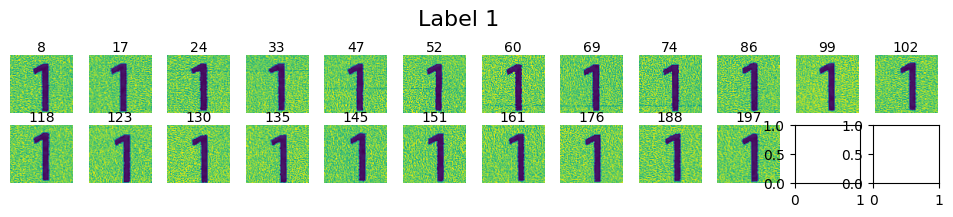

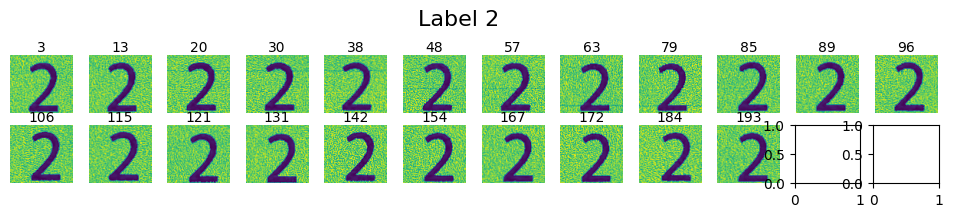

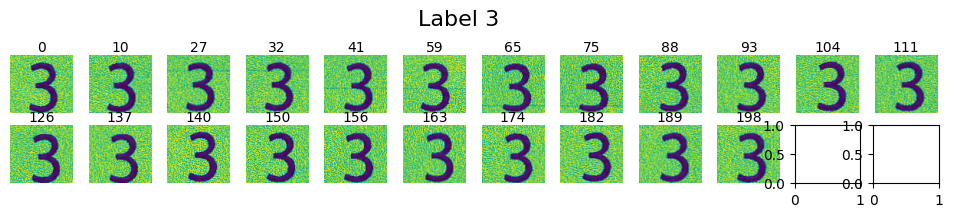

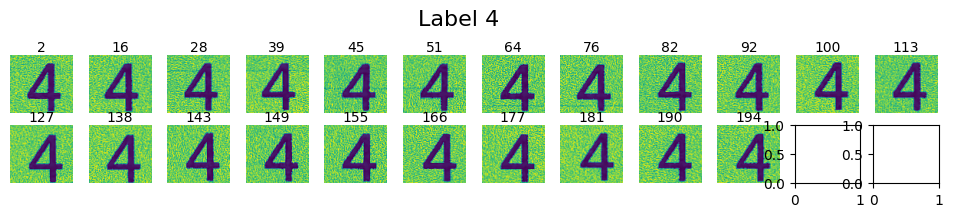

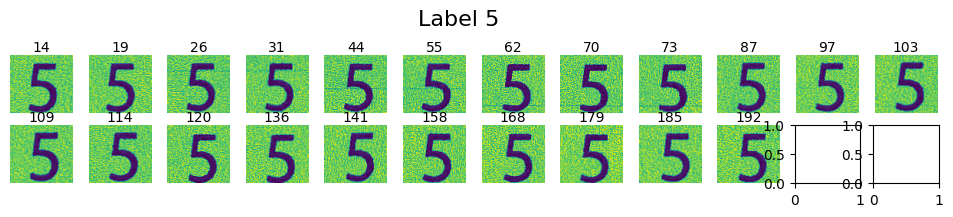

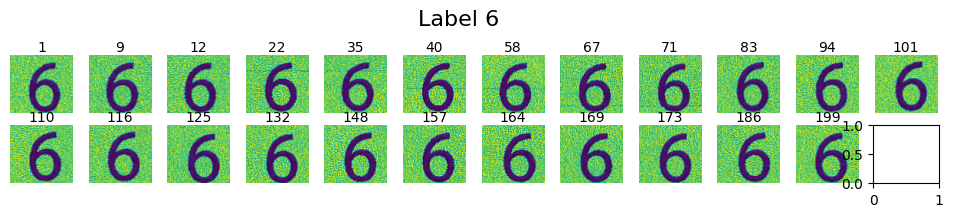

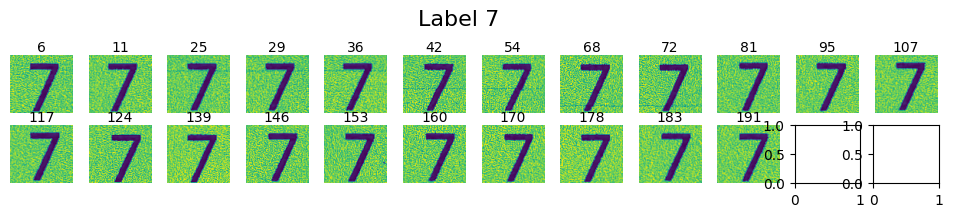

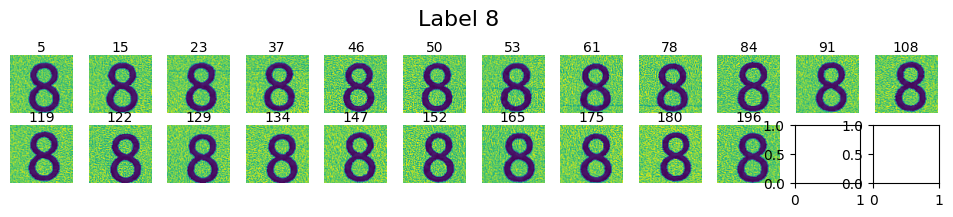

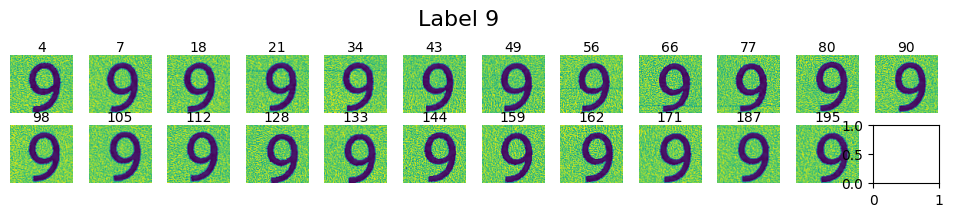

In [22]:
visualize_symbols(roi_numbers, true_labels)

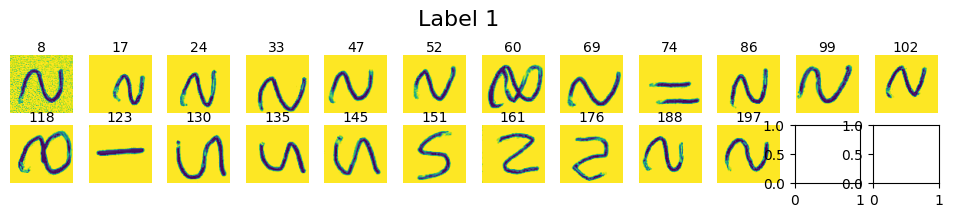

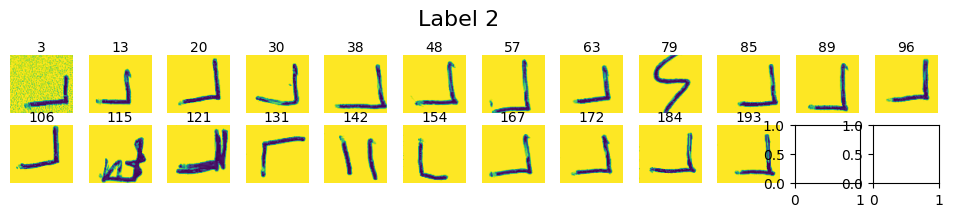

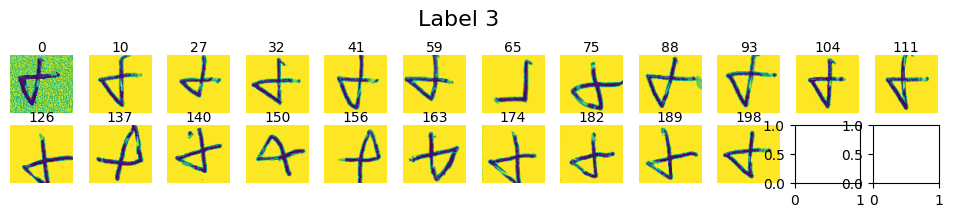

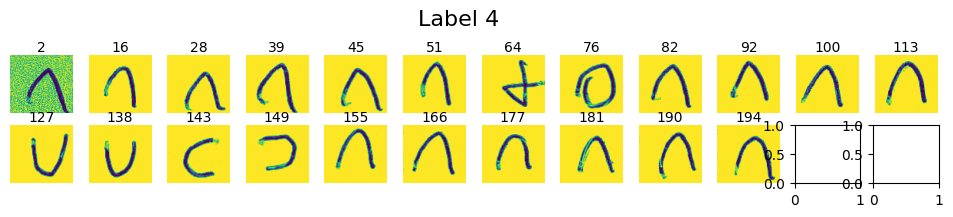

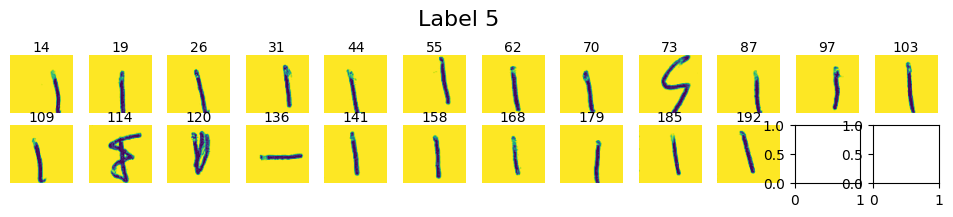

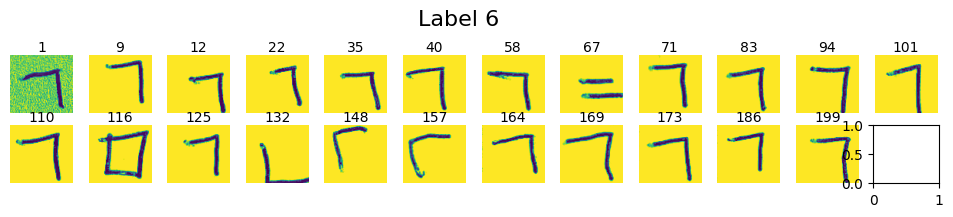

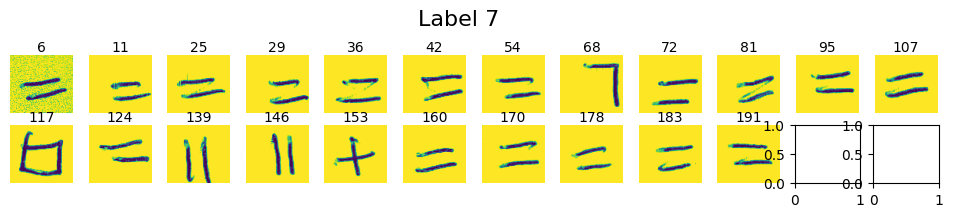

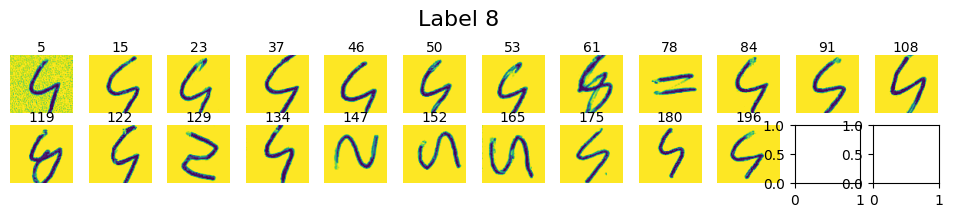

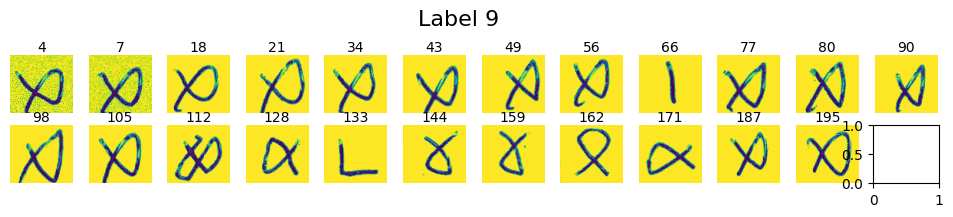

In [23]:
visualize_symbols(roi_symbols, true_labels)

# Classification

In [24]:
# Redimension pictures
new_size = (56, 56)
pict = roi_symbols.astype(np.float32)
pict = pict.reshape(-1, pict.shape[1], pict.shape[2], 1)
symbols = np.empty((len(pict), new_size[0], new_size[1]))
for i in range(len(pict)):
    img_resized = cv.resize(pict[i], new_size, interpolation=cv.INTER_AREA)
    symbols[i] = img_resized
#all_but9 = np.nonzero(manual_labels != 9)
#symbols = symbols[all_but9]
print(symbols.shape)

(200, 56, 56)


In [25]:
# Normalize the pixel values of the images to be between 0 and 1
symbols = symbols / 255

In [39]:
best_sofar = "model_CS_3scan_Epoch40_20240503.keras"
# Load model
model = keras.models.load_model(best_sofar)

# Check its architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,133 (4.70 MB)

 Trainable params: 410,377 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 820,756 (3.13 MB)

In [40]:
# Generate predictions for the test set
symbols_predicted = model.predict(symbols)
# Use np.argmax to find the index of the maximum value in the first set of predictions,
# which corresponds to the model's predicted class label for the first image
# Pour détecter les erreur: ajouter une conditions : si
predicted_label = np.argmax(symbols_predicted[0])+1
# Convert the model's predictions from probability distributions to class labels
# by finding the index of the max probability for each prediction and adding 1
symbols_predicted_labels = [np.argmax(i) + 1 if max(i) > 0.7 else 0 for i in symbols_predicted]
print(symbols_predicted_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[4, 6, 4, 2, 0, 8, 0, 0, 1, 6, 3, 7, 6, 2, 0, 0, 4, 1, 9, 0, 2, 9, 6, 9, 1, 7, 5, 3, 4, 0, 2, 5, 3, 1, 9, 6, 2, 8, 2, 4, 6, 3, 0, 1, 0, 4, 9, 1, 2, 0, 8, 4, 1, 0, 0, 0, 9, 2, 6, 3, 1, 3, 0, 2, 3, 2, 5, 7, 0, 1, 0, 6, 0, 8, 0, 3, 9, 9, 3, 8, 9, 2, 4, 6, 8, 2, 1, 2, 0, 2, 0, 8, 4, 0, 6, 7, 2, 5, 9, 1, 4, 6, 1, 0, 3, 9, 2, 0, 8, 3, 6, 3, 3, 4, 3, 2, 9, 1, 1, 3, 3, 2, 8, 3, 1, 6, 0, 0, 1, 3, 0, 4, 5, 2, 8, 1, 7, 2, 2, 0, 3, 5, 9, 4, 3, 0, 3, 1, 4, 0, 3, 8, 4, 3, 2, 4, 3, 4, 0, 0, 2, 0, 8, 3, 6, 4, 4, 2, 5, 6, 0, 1, 2, 6, 3, 8, 2, 4, 7, 0, 8, 4, 3, 7, 2, 5, 6, 3, 1, 3, 4, 7, 5, 2, 4, 9, 0, 1, 3, 6]


In [41]:
print(symbols_predicted[9])
print(predicted_label)
print(symbols_predicted[9].max() > 0.5)

[2.42025169e-04 1.12271020e-02 1.05638755e-07 7.48819411e-02
 1.63713489e-02 7.92514622e-01 1.52982480e-04 5.81236440e-04
 1.04028560e-01]
4
True


# Affichage des résultats

In [42]:
# Function to visualize detected boxes on scanned resultsheet
def plot_results(image, boxes):
    image_copy = image.copy()
    for i, gbox in enumerate(boxes) :
        x, y, w, h = gbox
        if (symbols_predicted_labels[i] == 0) :
            cv.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
        elif (symbols_predicted_labels[i] == true_labels[i]) :
            cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else :
            cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
            #print(f'Le symbole {i+1}, énoncé: {true_labels[i]}, est détecté comme: {symbols_predicted_labels[i]}, proba:{symbols_predicted[i].max()}')
    plt.figure(figsize=(10,8))
    plt.imshow(cv.cvtColor(image_copy, cv.COLOR_BGR2RGB))
    plt.title("Test Correction")
    plt.axis('off')
    plt.show()

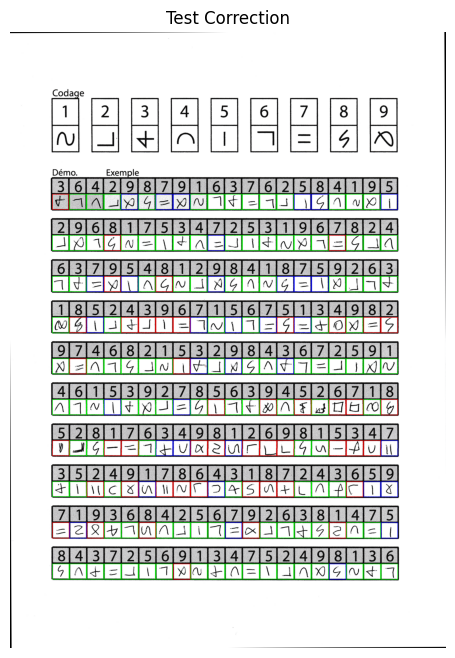

In [43]:
plot_results(img_rot, box[symbols_index])

In [44]:
# Manual correction of the resultsheet, used to assess model errors
# For Test.png
manual_labels = np.array([3, 6, 4, 2, 9, 8, 7, 9, 1, 6, 3, 7, 6, 2, 5, 8, 4, 1, 9, 5,
                        2, 9, 6, 8, 1, 7, 5, 3, 4, 7, 2, 5, 3, 1, 9, 6, 7, 8, 2, 4,
                        6, 3, 7, 9, 5, 4, 8, 1, 2, 9, 8, 4, 1, 8, 7, 5, 9, 2, 6, 3,
                        0, 0, 5, 2, 3, 2, 5, 7, 6, 1, 5, 6, 7, 8, 7, 3, 0, 9, 7, 8, 
                        9, 7, 4, 6, 8, 2, 1, 5, 3, 2, 9, 8, 4, 3, 6, 7, 2, 5, 9, 1,
                        4, 6, 1, 5, 3, 9, 2, 7, 8, 5, 6, 3, 0, 4, 0, 0, 0, 0, 0, 0,
                        5, 2, 8, 0, 7, 6, 3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0,
                        3, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 5, 0,
                        7, 0, 0, 0, 6, 0, 4, 2, 5, 6, 7, 0, 2, 6, 3, 8, 0, 4, 7, 5,
                        8, 4, 3, 7, 2, 5, 6, 9, 1, 3, 4, 7, 5, 2, 4, 9, 8, 1, 3, 6])

In [45]:
# Manual correction of the resultsheet, used to assess model errors
# For Test2.png
manual_labels = np.array([3, 6, 4, 2, 0, 8, 7, 9, 1, 6, 3, 7, 0, 2, 5, 8, 4, 1, 9, 5,
                        2, 9, 6, 0, 1, 7, 5, 3, 4, 7, 2, 5, 3, 1, 9, 6, 7, 0, 2, 4,
                        6, 3, 7, 9, 5, 0, 8, 1, 2, 9, 8, 4, 1, 8, 7, 5, 9, 2, 6, 3,
                        1, 8, 5, 2, 4, 3, 9, 6, 7, 1, 5, 6, 7, 5, 1, 3, 4, 9, 8, 2, 
                        9, 0, 4, 6, 8, 2, 1, 5, 3, 2, 9, 8, 4, 3, 6, 7, 0, 5, 9, 1,
                        4, 6, 1, 5, 3, 9, 2, 7, 8, 5, 6, 3, 9, 4, 5, 2, 6, 7, 1, 8,
                        5, 2, 8, 1, 7, 6, 3, 4, 9, 8, 1, 2, 6, 9, 8, 1, 5, 3, 4, 0,
                        3, 5, 2, 4, 9, 1, 7, 8, 6, 4, 3, 1, 8, 7, 2, 0, 3, 6, 5, 9,
                        7, 1, 9, 3, 6, 8, 4, 2, 5, 6, 7, 9, 2, 6, 3, 8, 1, 4, 7, 5,
                        8, 4, 3, 7, 2, 5, 6, 9, 1, 3, 4, 7, 5, 2, 0, 9, 8, 1, 3, 6])


Text(50.722222222222214, 0.5, 'Truth')

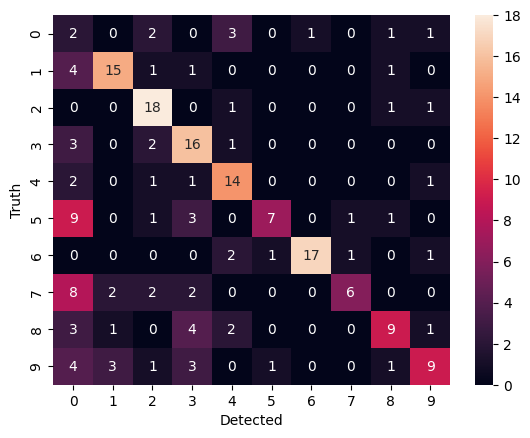

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(manual_labels, symbols_predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel("Detected")
plt.ylabel("Truth")

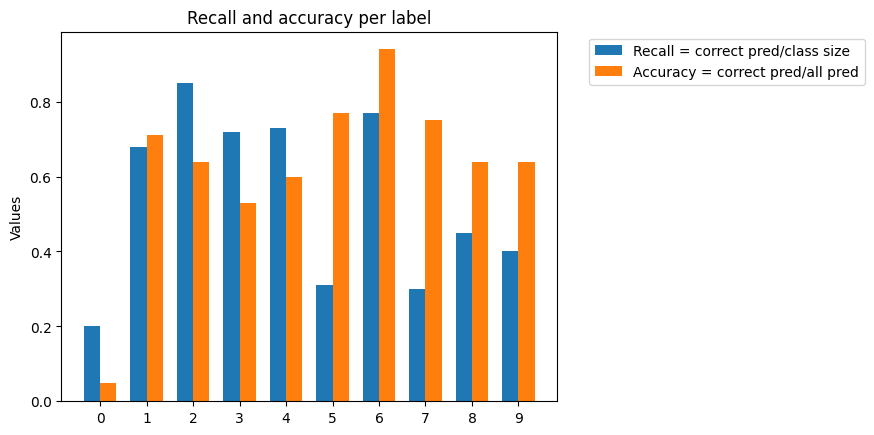

In [47]:
# Accuracy = correct prediction/Total prediction
# Recall = correct prediction/True values = TPR = sensitivity
recall = [truncate(cm[i, i]/cm[i, :].sum()) for i in range(0,10)]
accuracy = [truncate(cm[i, i]/cm[:, i].sum()) for i in range(0,10)]

x = np.arange(10)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='Recall = correct pred/class size')
rects2 = ax.bar(x + width/2, accuracy, width, label='Accuracy = correct pred/all pred')

ax.set_ylabel('Values')
ax.set_title('Recall and accuracy per label')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We want to minimize false positives = symbols labelled correct while they are:

*	an error : FP_error

*	or a different symbol : FP_symbol

It is fine to have false negative = symbols which are correct but are labelled as:

*	an error : FN_error

*	or a different symbol: FN_symbol

In [48]:
# Add custom metric false neg false pos
print(cm)
FP_error = np.array([cm[0, i] for i in range(1, 9)])
FN_error = np.array([cm[i, 0] for i in range(1, 9)])
# /!\ delete uses the index in the np.arange(1,10) not from the cm, which is where the i-1 comes from
FP_symbol = np.array([cm[np.delete(np.arange(1, 9), i-1), i].sum() for i in range(1, 9)])
FN_symbol = np.array([cm[i, np.delete(np.arange(1, 9), i-1)].sum() for i in range(1, 9)])
print(FN_error)

[[ 2  0  2  0  3  0  1  0  1  1]
 [ 4 15  1  1  0  0  0  0  1  0]
 [ 0  0 18  0  1  0  0  0  1  1]
 [ 3  0  2 16  1  0  0  0  0  0]
 [ 2  0  1  1 14  0  0  0  0  1]
 [ 9  0  1  3  0  7  0  1  1  0]
 [ 0  0  0  0  2  1 17  1  0  1]
 [ 8  2  2  2  0  0  0  6  0  0]
 [ 3  1  0  4  2  0  0  0  9  1]
 [ 4  3  1  3  0  1  0  0  1  9]]
[4 0 3 2 9 0 8 3]


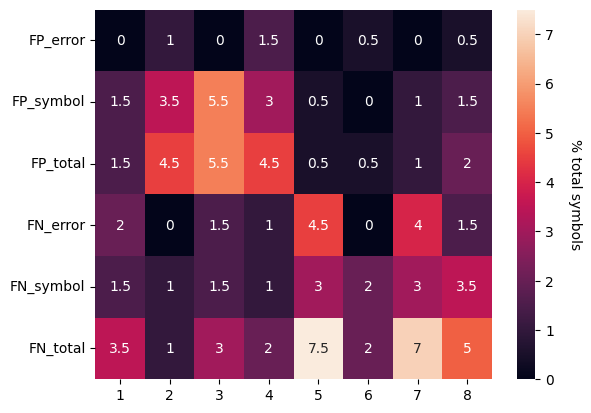

In [49]:
FP_total = FP_error + FP_symbol
FN_total = FN_error + FN_symbol
metrics = np.vstack((FP_error, FP_symbol, FP_total, FN_error, FN_symbol, FN_total))
# Normalize on total number of samples
metrics_n = metrics/cm.sum()*100
heatmap = sns.heatmap(metrics_n, annot=True)
cbar = heatmap.collections[0].colorbar
cbar.set_label('% total symbols', rotation=270, labelpad=20)
heatmap.set_xticklabels(range(1, 9))
heatmap.set_yticklabels(["FP_error", "FP_symbol", "FP_total", "FN_error", "FN_symbol", "FN_total"], rotation = 0)
plt.show()

In [50]:
# Metrics for all labels :
print(f'False positive : {metrics_n.sum(axis=1)[2]}% of total symbols')
print(f'False negative : {metrics_n.sum(axis=1)[5]}% of total symbols')

False positive : 20.0% of total symbols
False negative : 31.0% of total symbols


1
0
0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9


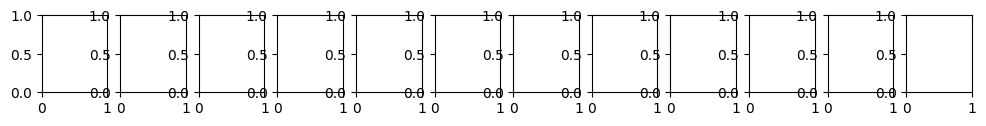

2
0
0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
1
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9


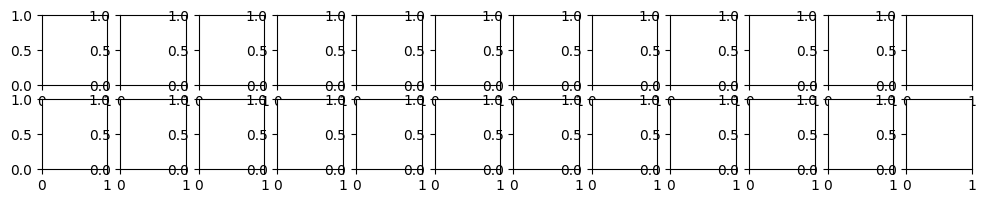

In [108]:
#visualize_symbols(roi_symbols, true_labels)

for label in [0, 1]:
    label_mask = (manual_labels == label)
    roi_indices = np.where(label_mask)[0]
    n_rows = math.ceil(len(roi_symbols[roi_indices]) / 12)
    print(n_rows)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))
    for i, pixels in enumerate(roi_symbols[roi_indices]):
        row = i // 12
        col = i % 12
        print(row)
        print(col)
        ax = axs[row, col] if n_rows > 1 else axs[row]
    plt.show()

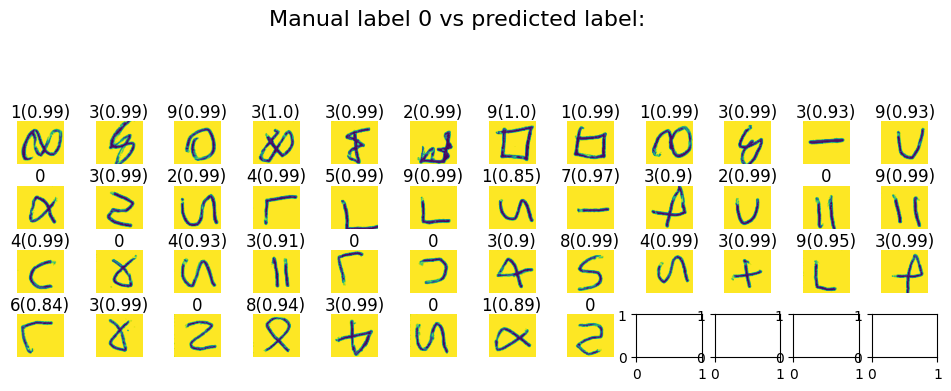

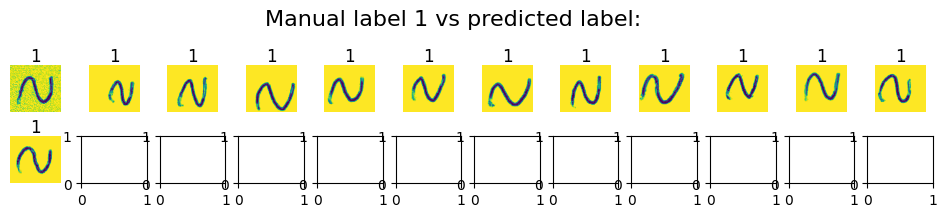

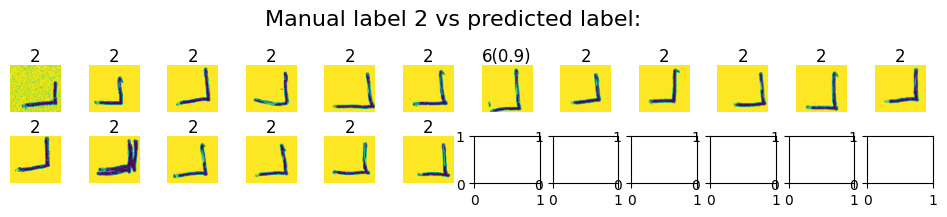

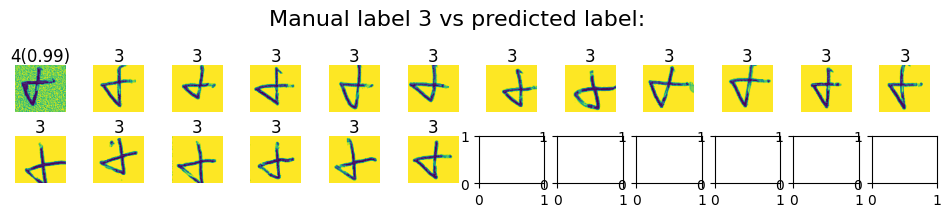

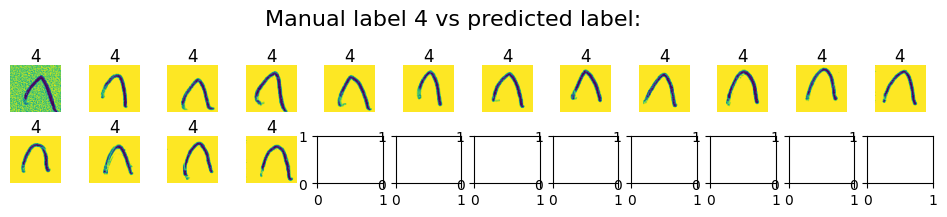

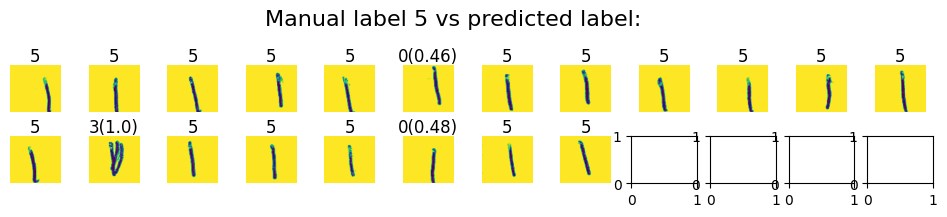

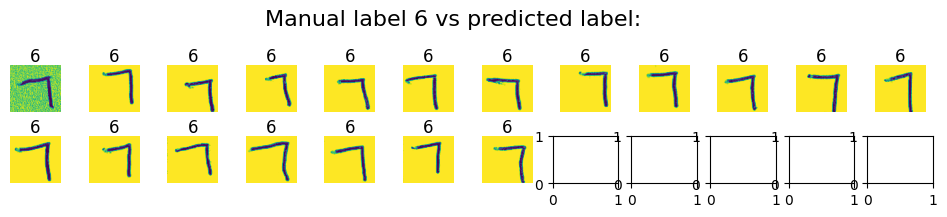

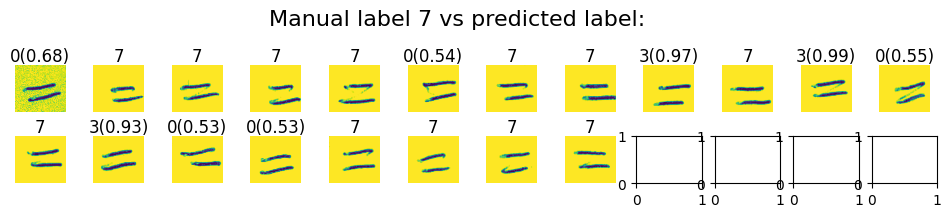

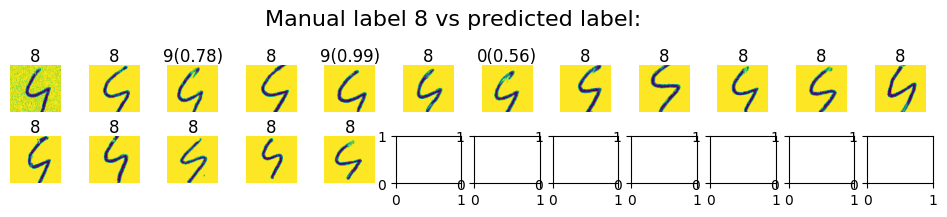

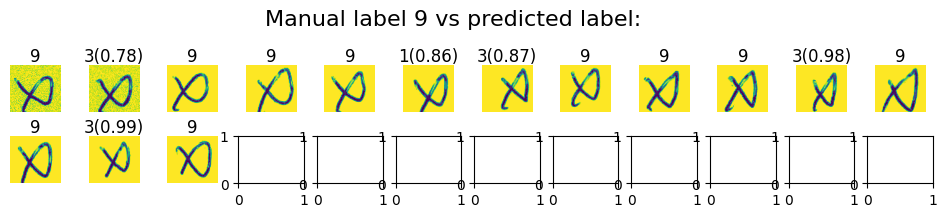

In [34]:
# Display symbols affected to each manual label (truth) annotated with model's prediction
# When incorrect, it is associated with the probability of that prediction between brackets.
def truncate(n):
    return int(n * 100) / 100
def dynamic_legend(indice):
    if symbols_predicted_labels[indice] == manual_labels[indice] :
        legend = f'{symbols_predicted_labels[indice]}'
    else :
        legend = f'{symbols_predicted_labels[indice]}({truncate(symbols_predicted[roi_indices[i]].max())})'
    return legend
# Annotation: affichage des symboles affectés à chaque true_label : détection des erreurs
for label in np.unique(manual_labels):
    label_mask = (manual_labels == label)
    roi_indices = np.where(label_mask)[0]

    n_rows = math.ceil(len(roi_symbols[roi_indices]) / 12)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))

    for i, pixels in enumerate(roi_symbols[roi_indices]):
        row = i // 12
        col = i % 12
        ax = axs[row, col] if n_rows > 1 else axs[col]
        ax.imshow(pixels)
        ax.text(0.5, 1, dynamic_legend(roi_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=12)
        ax.axis('off')
    fig.suptitle(f'Manual label {label} vs predicted label:', fontsize=16)
    fig.subplots_adjust(top=0.7, hspace = 0.5)
    plt.show()

In [ ]:
# Score: compte le nombre de ligne (20 par ligne) : en fait le nombre de cases
# On soustrait le nombre d'erreurs